# DSM020 CW2 - Data extraction

## Objective

This notebook contains all the Python code needed to extract the revised data required for the objective of CW2. It also includes the preparation steps to make the data fit for model building. 


The data extracted is book meta data, comprising of the fields: title; synopsis; ISBN number; and subject category. The source of the data is via the retailer Waterstones' website (www.waterstones.co.uk). 


Waterstones's data was chosen because:
 - its metadata includes the BIC subject category classification (Waterstones Booksellers Ltd, 2021) for each book
 - the data was easily obtained unlike for other retailers which had captchas set in place to stop data scraping
 - there are no T&C's attached to the access and usage of data on Waterstones's website
 
 
For practical & ethical reasons the amount of data to be extracted was limited. A web crawler was created to extract metadate (title, synopsis, ISBN code and subject category) from the first 16 pages of results for each subject category with the aim of extracting data from around 300 books per category.


Waterstones does not have any 'acceptable use policy' or other similar terms and conditions listed on its website. Nonetheless I have limited my request for data to small volumes so as not to compromise the server. Furthermore the data extracted is not personal data and will be used only for academic purposes and not for commerical gain.


A web crawler was created to extract the data. Bestselling books were selected in each of the selected categories as low selling books may not be representative of the subject category or be incorrectly assigned.

## Contents

1. Python set up
2. Data extraction
3. Data preparation
4. Finalised dataset
5. References

## 1. Python set up
Load all the required Python packages and other set-up requirements for code to run as required.

In [1]:
# Data manipulation
import pandas as pd
from copy import copy
import re
import string
from functools import reduce

# Numeric manipulation
import numpy as np
import math

# Charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.pylab as plt1
# Installed wordcloud in a terminal in Jupyter with this powershell command:
# PS C:\Users\jmd05\Documents>cd C:\Users\jmd05\anaconda3
# PS C:\Users\jmd05\anaconda3\> conda install -c conda-forge wordcloud=1.6.0 

# Web scraping & APIs
headers={"User-Agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"}
from bs4 import BeautifulSoup
import requests
from isbnlib import meta, desc, info, is_isbn13, classify
from isbnlib.registry import bibformatters
import time

# NLP
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, webtext
from nltk.probability import FreqDist
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from scipy.spatial import distance_matrix
from nltk.stem import WordNetLemmatizer
# Map any punctuation characters to white space
translator=str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

# Other
import warnings

## 2. Data extraction

In [ ]:
def waterstones_crawler(url,subject,max_pages):
    '''
    This function crawls through the web page supplied in the function call 
    pulling the required metadata from each book on the page using
    get_book_info() defined below
    '''
    book_data=[]
    page=1
    # Loop through the pages of results for each URL
    while page<=max_pages:   
        # Get all the text from the current page of results
        url1=url+str(page)
        source_code=requests.get(url1,headers)
        plain_text=source_code.text
        plain_text_clean=plain_text.strip()
        soup=BeautifulSoup(plain_text_clean,'html')   
        # Extract the title, synopsis, subject category & ISBN 
        # of each individual book on current page using function get_item_desc
        for link in soup.find_all('a', {'class':'title link-invert dotdotdot'}):
            href='https://www.waterstones.com'+link.get('href')
            book_info=get_book_info(href,subject)
            book_data.append(book_info)  
        page+=1
    return book_data

# Extract the required data for an individual book
def get_book_info(item_url,subject):
    # Get all the text from the current book link
    source_code=requests.get(item_url,headers)
    plain_text=source_code.text
    plain_text_clean=plain_text.strip()
    soup=BeautifulSoup(plain_text_clean)
    # Get title
    title=soup.find('span',{'class':'book-title'}).string
    # Get synopsis
    synopsis=soup.find('div', {'itemprop':'description', 'id':'scope_book_description'}).find_all('p')
    # Get subject category 
    subject=subject
    # Get ISBN
    isbn=soup.find('span',{'itemprop':'isbn'}).string
    return title, synopsis, subject, isbn

# Extract book information for 8 selected subject categoris
spor=waterstones_crawler('https://www.waterstones.com/category/sports-leisure/sortmode/bestselling/page/','sports-leisure',16)
hist=waterstones_crawler('https://www.waterstones.com/category/history/sortmode/bestselling/page/','history',16)
roma=waterstones_crawler('https://www.waterstones.com/category/romantic-fiction/sortmode/bestselling/page/','romantic-fiction',16)
reli=waterstones_crawler('https://www.waterstones.com/category/spirituality-beliefs/sortmode/bestselling/page/','spirituality-beliefs',16)
scie=waterstones_crawler('https://www.waterstones.com/category/science-technology-medicine/sortmode/bestselling/page/','science-technology-medicine',16)  
food=waterstones_crawler('https://www.waterstones.com/category/food-drink/sortmode/bestselling/page/','food-drink',16)
busi=waterstones_crawler('https://www.waterstones.com/category/business-finance-law/sortmode/bestselling/page/','business-finance-law',16)  
ente=waterstones_crawler('https://www.waterstones.com/category/entertainment/sortmode/bestselling/page/','entertainment',13)

# Bring together all data into one dataframe & save as csv
df_spor=pd.DataFrame(spor,columns=['Title','Synopsis','Subject','ISBN'])
df_hist=pd.DataFrame(hist,columns=['Title','Synopsis','Subject','ISBN'])
df_roma=pd.DataFrame(roma,columns=['Title','Synopsis','Subject','ISBN'])
df_reli=pd.DataFrame(reli,columns=['Title','Synopsis','Subject','ISBN'])
df_scie=pd.DataFrame(scie,columns=['Title','Synopsis','Subject','ISBN'])
df_food=pd.DataFrame(food,columns=['Title','Synopsis','Subject','ISBN'])
df_busi=pd.DataFrame(busi,columns=['Title','Synopsis','Subject','ISBN'])
df_ente=pd.DataFrame(ente,columns=['Title','Synopsis','Subject','ISBN'])
list_all = [df_spor, df_hist, df_roma, df_reli, df_scie, df_food, df_busi, df_ente] 
df_all_16 = pd.concat(list_all,ignore_index=True)
df_all_16.to_csv("all_16.csv")

## 3. Data preparation
It is important to clean the data ahead of any exploratory analysis or application of algorithms. For example, mixed-type fields could cause an algorithm to interpret a field incorrectly. For the book data I need to ensure only the correct type of characters are present, the data is fully populated and that issues of duplication and text length are addressed. The following cleaning steps are undertaken:

    a. Clean text features 
    b. Clean numeric features
    c. Treat missing values
    d. Split synopsis into individual words & remove redundant words
    e. Lemmatize words
    f. Remove outliers
    g. Remove books assigned to more than one subject category
    h. Review a cleaned data case

In [3]:
df=pd.read_csv("all_16.csv", index_col=0, dtype = str)
#df.shape # 3,072, 4
df.head()

,Title,Synopsis,Subject,ISBN
0,Too Many Reasons to Live (Hardback),[<p><em>I'm not giving in until my last breath...,sports-leisure,9781529073249
1,Breath: The New Science of a Lost Art (Paperback),[<p>There is nothing more essential to our hea...,sports-leisure,9780241289129
2,One by One (Paperback),[<p><b>'The sense of dread deepens as the snow...,sports-leisure,9781784708085
3,The Chimp Paradox: The Acclaimed Mind Manageme...,[<p><em>The Chimp is the emotional machine tha...,sports-leisure,9780091935580
4,And it was Beautiful: Marcelo Bielsa and the R...,[<p>When Marcelo Bielsa was appointed head coa...,sports-leisure,9781841885162


#### a. Clean text fields
Undertake basic cleaning to remove superfluous characters from strings. 

In [4]:
def text_clean(df):
    for i in df.columns:
        # Remove leading & trailing white space & EOF markings
        df[i]=df[i].map(lambda x: x.strip()) 
        # Remove HTML tags
        df[i]=df[i].apply(lambda x: re.sub('<[^<]+?\>',' ',x))
        # Replace punctuation characters with a single white space
        df[i]=df[i].apply(lambda x: x.translate(translator))
        # Replace consecutive white spaces with a single white space
        df[i]=df[i].apply(lambda x: re.sub('\s+',' ',x))
        # Remove leading & trailing white space & EOF markings
        df[i]=df[i].map(lambda x: x.strip()) 
        # Set all features to one case to ensure consistent treatment of characters on-going
        df[i]=df[i].str.lower()                               
        # Remove superfluous book-type descriptor
        df[i] = df[i].map(lambda x: x.replace("paperback","").replace("hardback","")) 
    return df

df1=df.copy()
df1=text_clean(df1)

#### b. Clean numeric fields
Check that ISBN is not corrupted with alphabetical characters & of the required length.

In [5]:
# Check for erraneous non-numeric characters in 'ISBN'
def is_num(z):
    try:
        int(z)
    except ValueError:
        return False
    else:
        return True
    
isbn_num_chk=df1['ISBN'].apply(lambda x: is_num(x))
isbn_num_chk.value_counts()

True    3072
Name: ISBN, dtype: int64

In [6]:
# Check for length of ISBN
# Should be 10 digits for books published before 2006 & 13 digits for books published after
isbn_len_chk=df1['ISBN'].apply(lambda x: len(str(x)))
isbn_len_chk.value_counts(dropna=False)

13    3072
Name: ISBN, dtype: int64

#### c. Treat missing values
Missing synopsis data cannot be inferred so it needs to be populated using alternative sources of data. Extract data from free APIs - Google Books, Wikipedia & OpenLibrary - through the isbnlib package - with ISBN being the match key for the join.

In [7]:
# Check for missing data

dic={}
for i in df1.columns:
    dic[i]=len(df1[df1[i]==''])
print(dic)

# 632/3,072 (21%) of titles have missing synopsis
# As this is a significant number will need to populate from another data source

{'Title': 0, 'Synopsis': 632, 'Subject': 0, 'ISBN': 0}


In [ ]:
# Using time.sleep() function here to reduce the possibility of a HTTPError warning (4 minute run time)
def get_synopsis(synopsis, isbn):
    '''
    Check if the synopsis field of a book is missing and if so
    to populate it from one of three open source book libraries
    '''
    if synopsis=='':
            time.sleep(2)
            Service='wiki'
            Wiki=desc(isbn)
            if Wiki!='':
                return Wiki
            else:
                Service='goob'
                Goob=desc(isbn)
                if Goob!='':
                    return Goob
                else:
                    Service='openl'
                    Openl=desc(isbn)
                    if Openl!='':
                        return Openl
                    else:
                        return '' 
    else:
        return synopsis
    
df1['Synopsis']=df1.apply(lambda x: get_synopsis(x['Synopsis'],x['ISBN']), axis=1)

# Clean the data as per (3)(A) above
df2=df1.copy()
df2=text_clean(df2)

# Check population rate
print(len(df2[df2['Synopsis']=='']))
# 119/3,072 (3.9%) of titles still have missing synopsis

In [10]:
# Drop books with no synopsis
df2=df2.loc[df2.Synopsis != '']
#df2.shape # 2,953,4

#### d. Split synopsis into individual words & remove redundant words
- Using stop words, remove words which are abundant across all books like 'a' & 'the' and have no unique value for analysis. Also removed the word 'book' which appears in most synopses as an unnecessary reference to itself
- For practical reasons also removed words which contain digits

In [11]:
# Get standard stop words in English 
stop=stopwords.words('english')

# Split words in each synopsis, remove stop words & remove words containing digits
df2['Synopsis1']=df2['Synopsis'].str.split().apply(lambda x: [item for item in x if item not in stop and item!='book'])\
.apply(lambda x: [item for item in x if item.isalpha()])

#### e. Lemmatize words
Here I want to reduce the number of words that comprise the same information. For ease of interpretation we can use a lemmatization technique to stem words to their root word but whereby the root which is an actual word, unlike for other stemming approaches

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    lem_list=[]
    for word in x:
        lem_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return lem_list

df2['Synopsis2']=df2['Synopsis1'].apply(lambda x: lemmatize(x))

#### f. Remove outliers 
The chart & table below shows the distribution of synopsis lengths being normally distribution with similar mean and median but with a slight right skew. From an analysis perspective a long synopsis will provide more information on the subject matter of a book than a shorter one. Around 5% of books have a synopsis of less than 30 words (which is approximately the mean minus 1.7 standard deviations) which could make text similarity analysis less robust for these books. So it was decided to remove these books from the analysis.

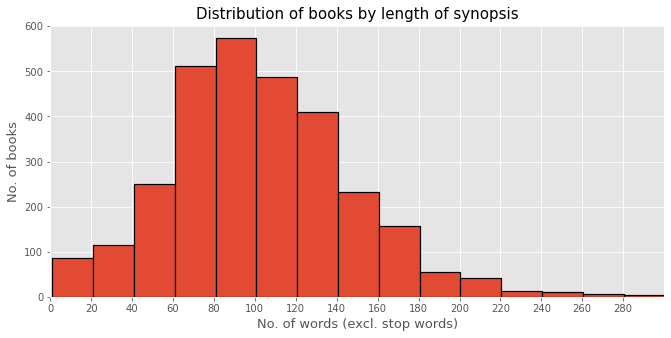

In [13]:
# Plot distribution of synopsis lengths

# Calculate length of synopsis without stop words for each book
df2['Synopsis2_len']=df2['Synopsis2'].map(len)

#Plot histogram
plt.figure(figsize=(11,5))
plt.style.use('ggplot')
n = math.ceil((df2['Synopsis2_len'].max() - df2['Synopsis2_len'].min())/20)
plt.hist(df2['Synopsis2_len'], bins=n, edgecolor='black', linewidth=1.2)
x=np.arange(0, 300, 20)
xlabels = [f'{label:,}' for label in x]
plt.xticks(x, xlabels)
plt.xlim([0,300])
plt.title("Distribution of books by length of synopsis",fontsize=15)
plt.xlabel("No. of words (excl. stop words)", fontsize=13)
plt.ylabel("No. of books", fontsize=13)
plt.show()

In [14]:
# Identify & remove outliers
stats1=df2['Synopsis2_len'].describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.25,0.5,0.75,0.9,0.99,1]).to_frame()\
.reset_index().rename(columns = {'index':'Statistic', 'Synopsis2_len':'No. words'})
stats1['No. words']=stats1['No. words'].round().map(int)
stats1[1:]

,Statistic,No. words
1,mean,102
2,std,45
3,min,1
4,1%,11
5,2%,15
6,3%,21
7,4%,26
8,5%,30
9,25%,72
10,50%,99


In [ ]:
# Drop books with synopsis less than 30 words
df2=df2.loc[df2.Synopsis2_len >= 30]
#df2.shape # 2,810, 7
# Removed 34 books

#### g. Remove books assigned to more than one subject category 
As multinomial classification models assume that each 'data case' is only assigned to one 'class' it is necessary to dedupe the books in the data to ensure each is assigned to only one subject category. One of the limitations of my POC is that this does compromise the BIC system which allows manual assignment to multiple categories - it recommends a maximum of three subject categories being selected- however this issue is ameliorated due to 92% of books being assigned to only one subject category.

In [16]:
# Check that proportion of books appearing in multiple subject categories
freq=df2.ISBN.value_counts(dropna=False)
freq.value_counts(dropna=False, normalize=True)

1    0.924172
2    0.070054
3    0.005774
Name: ISBN, dtype: float64

In [ ]:
# Dedupe those which appear in multiple subject categories
df3=df2.drop_duplicates(subset=["Title","ISBN"])
#df3.shape # 2,598, 7
# Removed 212 books (7.5%)

#### h. Review a cleaned observation
An example of the revised data shows the extent of the cleaning undertaken, notably the reduction in length of the synopsis  

In [18]:
print('Title before cleaning    : '+df.Title[4])
print('Title after cleaning     : '+df3.Title[4])
print('')
print('Subject before cleaning  : '+df.Subject[4])
print('Subject after cleaning   : '+df3.Subject[4])
print('')
print('ISBN before cleaning     : '+df.ISBN[4])
print('ISBN after cleaning      : '+df3.ISBN[4])
print('')
print('Synopsis before cleaning : '+df.Synopsis[4])
print('')
print('Synopsis after cleaning  : '+' '.join(sub for sub in df3.Synopsis2[4]))

Title before cleaning    : And it was Beautiful: Marcelo Bielsa and the Rebirth of Leeds United (Hardback)
Title after cleaning     : and it was beautiful marcelo bielsa and the rebirth of leeds united

Subject before cleaning  : sports-leisure
Subject after cleaning   : sports leisure

ISBN before cleaning     : 9781841885162
ISBN after cleaning      : 9781841885162

Synopsis before cleaning : [<p>When Marcelo Bielsa was appointed head coach of Leeds United in the summer of 2018, the club had just finished 13th in the Championship - their 15th consecutive season outside the top flight - and were defined as much by their excesses and disasters off the pitch as their lack of success on it. Bielsa changed everything.</p>, <p>In guiding Leeds back to the promised land of the Premier League, he has transformed the club into a vastly more dynamic, entertaining and professional outfit, fully endearing himself to the Leeds faithful and capturing the imaginations of football fans around the wo

In [21]:
# Check the final distribution of books by subject category
df3.Subject.value_counts(dropna=False)

romantic fiction               363
history                        355
food drink                     345
sports leisure                 335
entertainment                  321
spirituality beliefs           305
science technology medicine    294
business finance law           280
Name: Subject, dtype: int64

## 4. Finalised dataset

In [22]:
# Save cleaned data
df3.to_csv(r"all_16_clean.csv")

## 5. References

BIC and Nielsen Book Services Ltd (2010). BIC Standard Subject Categories & Qualifiers - General Guidelines for Users, https://www.bic.org.uk/files/pdfs/110121%20BIC2%20User%20Guidelines%20Rel%204.0.pdf